# `Modeling`



In [1]:
#pip install xgboost

`import necessary libraries`

In [2]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random 


In [3]:
# Loading the 'provider' data
provider = pd.read_csv('provider.csv')
provider.drop(provider.columns[0], axis=1, inplace=True)
provider.head()

,Provider,inp_out,inp_out.1,ClmAdmitDiagnosisCode,DiagnosisGroupCode,AttendingPhysician,OperatingPhysician,OtherPhysician,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,settlement_days.1,Days_Admit,Total_deductible,Total_deductible.1,Total_reimbursible,Total_reimbursible.1,ClaimID,State,County,PotentialFraud
0,PRV51001,20,5,11,5,14,5,8,15,19,...,0,1.000000,1361.040000,34026,20221.200000,505530,25,1,7,0
1,PRV51003,70,62,58,58,44,7,22,56,80,...,0,2.424242,1668.545455,220248,10246.363636,1352520,132,3,23,1
2,PRV51004,149,0,25,0,38,19,26,64,88,...,0,0.000000,1057.704698,157598,6546.778523,975470,149,9,28,0
3,PRV51005,1164,0,158,0,6,6,4,426,679,...,0,0.000000,1013.544674,1179766,5531.168385,6438280,1165,4,26,1
4,PRV51007,69,3,17,3,10,5,7,26,40,...,0,0.222222,914.722222,65860,4779.722222,344140,72,2,6,0


In [4]:
# Change the dtype of the 'Provider' column to numerical
provider['Provider'] = provider['Provider'].str.extract('(\d+)').astype(int)


 Train-Test Split for Potential Fraud Prediction

In [5]:

# Perform train-test split for potential fraud prediction
X = provider.drop(columns = ['PotentialFraud', 'Provider'], axis = 1)
y = provider['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4328, 39)
X_test shape: (1082, 39)
y_train shape: (4328,)
y_test shape: (1082,)


In [6]:
# Splitting the data into different files
X_train.to_csv('x-train.csv')
y_train.to_csv('y-train.csv')
X_test.to_csv('x-test.csv')
y_test.to_csv('y-test.csv')


In [7]:
# Fitting the random forest classifier on the training data
r_cfl = RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

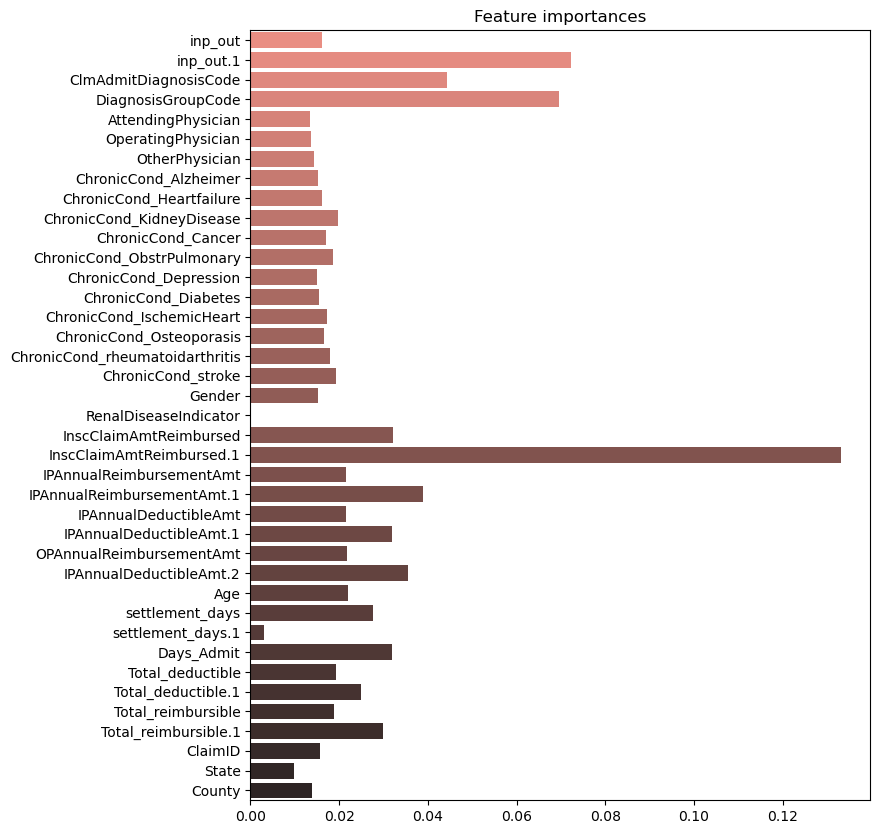

In [8]:
features = X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

In [9]:
# Dropping less important features
coef = coef[coef<0.005].index
X_train.drop(coef,axis=1,inplace=True)
X_test.drop(coef,axis=1,inplace=True)

In [10]:
# Default random forest classifier, with 1000 n_estimators and n_jobs set to -1
r_cfl = RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

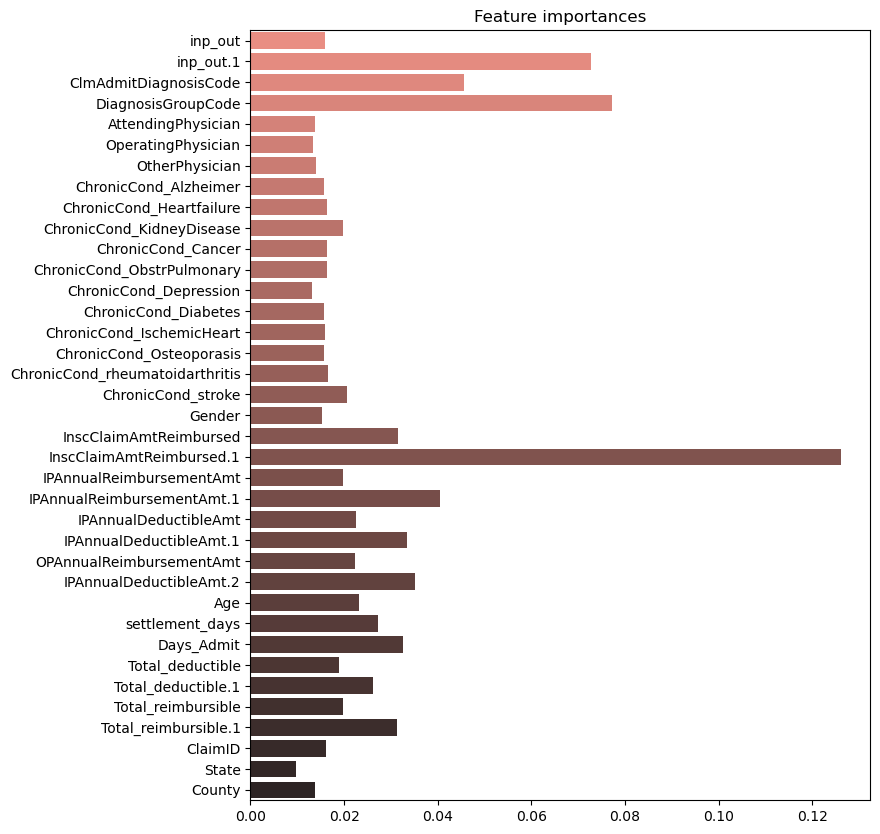

In [11]:
# Feature importance
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

Creating functions 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve

class BinaryClassificationModel:
    def __init__(self, classifier):
        self.classifier = classifier
    
    def train_and_predict(self, X_train, y_train, X_test):
        """Train the model on the training data and make predictions on the test data"""
        self.classifier.fit(X_train, y_train)
        self.y_pred = self.classifier.predict(X_test)
    
    def evaluate(self, y_test):
        """Evaluate the performance of the model using various metrics"""
        auc = roc_auc_score(y_test, self.y_pred)
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print("Classification Report:")
        print(classification_report(y_test, self.y_pred))

    def plot_confusion_matrix(self, y_test, cmap='GnBu'):
        """Display confusion matrix"""
        cm = confusion_matrix(y_test, self.y_pred)
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=['not_fraud', 'fraud'],
               yticklabels=['not_fraud', 'fraud'],
               xlabel='Predicted label',
               ylabel='True label',
               title='Confusion Matrix')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fmt = '.4g'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "darkblue")
        ax.grid(False)
        fig.tight_layout()
        plt.show()
    
    def plot_roc_curve(self, X_test, y_test):
        """Plot ROC curve"""
        if hasattr(self.classifier, "predict_proba"):
            y_score = self.classifier.predict_proba(X_test)[:, 1]  # Use predict_proba if available
        else:
            y_score = self.classifier.decision_function(X_test)  # Use decision_function as an alternative

        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.classifier.predict(X_train)
        test_pred = self.y_pred
        
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)

# 1. `Baseline Model`

### Building a random model

In [13]:
# Generating a baseline random model using our data

train_data_len = X_train.shape[0]

op_list = [0, 1]

train_predicted_y = np.zeros(train_data_len)
for i in range(train_data_len):
    train_predicted_y[i] = random.choice(op_list)

train_accuracy = np.mean(train_predicted_y == y_train)
train_f1_score = f1_score(y_train, train_predicted_y)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Training F1 Score: {:.2f}%".format(train_f1_score*100))

test_data_len = X_test.shape[0]
test_predicted_y = np.zeros(test_data_len)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(op_list)

test_accuracy = np.mean(test_predicted_y == y_test)
test_f1_score = f1_score(y_test, test_predicted_y)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test F1 Score: {:.2f}%".format(test_f1_score*100))

Training Accuracy: 50.14%
Training F1 Score: 15.11%
Test Accuracy: 50.00%
Test F1 Score: 15.34%


### `Checking and Handling Class Imbalance`

#### Sampling Techniques 

- Undersampling technique

- oversampling technique

- Hybrid sampling technique

### `under sampling technique`

In [14]:
# undersampling technique
from imblearn.under_sampling import NearMiss
from collections import Counter

# Create an instance of NearMiss with a sampling ratio of 0.8
ns = NearMiss(sampling_strategy=0.8)

# Apply undersampling to the training data
x_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

# Print the class distribution before and after undersampling
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 501, 1: 401})


`Decision Tree with undersampling`

In [15]:
# Decision tree classifier with undersampled data
classifier = DecisionTreeClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_ns, y_train_ns, X_test)
model.evaluate(y_test)

The model has an AUC score of 62.17%
-----------------------------------------------
The model's recall rate is 42.42%
-----------------------------------------------
The model's precision is 88.25%
-----------------------------------------------
The model's F1 score is 51.10%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.38      0.54       977
           1       0.13      0.87      0.23       105

    accuracy                           0.42      1082
   macro avg       0.55      0.62      0.38      1082
weighted avg       0.88      0.42      0.51      1082



`Random Forest with undersampling`

In [16]:
# Random forest default model with undersampled data
classifier = RandomForestClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_ns, y_train_ns, X_test)
model.evaluate(y_test)

The model has an AUC score of 67.40%
-----------------------------------------------
The model's recall rate is 51.11%
-----------------------------------------------
The model's precision is 89.29%
-----------------------------------------------
The model's F1 score is 59.88%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.47      0.64       977
           1       0.15      0.88      0.26       105

    accuracy                           0.51      1082
   macro avg       0.56      0.67      0.45      1082
weighted avg       0.89      0.51      0.60      1082



In [17]:
# Model evaluation
model.evaluate_overfitting(x_train_ns, y_train_ns, X_test, y_test)

Train set F1 score: 0.9987515605493134
Test set F1 score: 0.25806451612903225


### `oversampling technique`

In [18]:
# oversampling technique
# Assuming X_train and y_train are defined and assigned values correctly
os = RandomOverSampler(sampling_strategy=0.75)
x_train_os, y_train_os = os.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_os)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3927, 1: 2945})


`Decision tree with oversampling technique`

In [19]:
# Decision tree classidier with default parameters, on the oversampled data
classifier = DecisionTreeClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_os, y_train_os, X_test)
model.evaluate(y_test)

The model has an AUC score of 69.96%
-----------------------------------------------
The model's recall rate is 91.04%
-----------------------------------------------
The model's precision is 90.27%
-----------------------------------------------
The model's F1 score is 90.58%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       977
           1       0.55      0.44      0.49       105

    accuracy                           0.91      1082
   macro avg       0.74      0.70      0.72      1082
weighted avg       0.90      0.91      0.91      1082



In [20]:
# Model evaluation
model.evaluate_overfitting(x_train_os, y_train_os, X_test, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.4867724867724868


`random forest with over sampling technique`

In [21]:
# Random forest classifier with oversampled data
classifier = RandomForestClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_os, y_train_os, X_test)
model.evaluate(y_test)

The model has an AUC score of 72.17%
-----------------------------------------------
The model's recall rate is 91.96%
-----------------------------------------------
The model's precision is 91.25%
-----------------------------------------------
The model's F1 score is 91.51%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       977
           1       0.61      0.48      0.53       105

    accuracy                           0.92      1082
   macro avg       0.78      0.72      0.75      1082
weighted avg       0.91      0.92      0.92      1082



In [22]:
# Model evaluation
model.evaluate_overfitting(x_train_os, y_train_os, X_test, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5347593582887701


`Hybrid sampling technique`

In [23]:
# Applying SMOTETomek resampling technique on our data 
st = SMOTETomek()
x_train_st, y_train_st = st.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_st)))

The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3873, 1: 3873})


`Decision tree Hybrid sampling technique`

In [24]:
classifier = DecisionTreeClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_st, y_train_st, X_test)
model.evaluate(y_test)

The model has an AUC score of 75.72%
-----------------------------------------------
The model's recall rate is 87.62%
-----------------------------------------------
The model's precision is 90.25%
-----------------------------------------------
The model's F1 score is 88.68%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       977
           1       0.41      0.61      0.49       105

    accuracy                           0.88      1082
   macro avg       0.68      0.76      0.71      1082
weighted avg       0.90      0.88      0.89      1082



In [25]:
model.evaluate_overfitting(x_train_st, y_train_st, X_test, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.4885496183206108


`Random Forest hybrid sampling technique`

In [26]:
classifier = RandomForestClassifier()
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_st, y_train_st, X_test)
model.evaluate(y_test)

The model has an AUC score of 78.20%
-----------------------------------------------
The model's recall rate is 90.57%
-----------------------------------------------
The model's precision is 91.57%
-----------------------------------------------
The model's F1 score is 91.00%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       977
           1       0.51      0.63      0.56       105

    accuracy                           0.91      1082
   macro avg       0.74      0.78      0.76      1082
weighted avg       0.92      0.91      0.91      1082



In [27]:
model.evaluate_overfitting(x_train_st, y_train_st, X_test, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5641025641025641


Scaling the Numerical Features 


In [28]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(x_train_st)
X_test_scaled = scaler.transform(X_test)

## 2. `KNN Model`

In [29]:
classifier = KNeighborsClassifier()
model_knn = BinaryClassificationModel(classifier)

model_knn.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_knn.evaluate(y_test)

The model has an AUC score of 80.25%
-----------------------------------------------
The model's recall rate is 84.29%
-----------------------------------------------
The model's precision is 91.00%
-----------------------------------------------
The model's F1 score is 86.61%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       977
           1       0.35      0.75      0.48       105

    accuracy                           0.84      1082
   macro avg       0.66      0.80      0.69      1082
weighted avg       0.91      0.84      0.87      1082



In [30]:
model_knn.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Train set F1 score: 0.6766838472962348
Test set F1 score: 0.4817073170731708


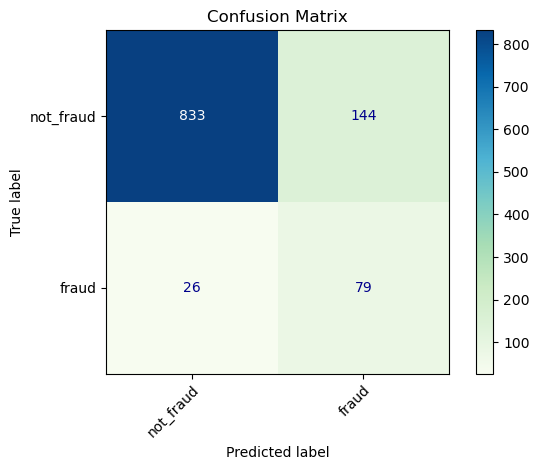

In [31]:
model_knn.plot_confusion_matrix(y_test)

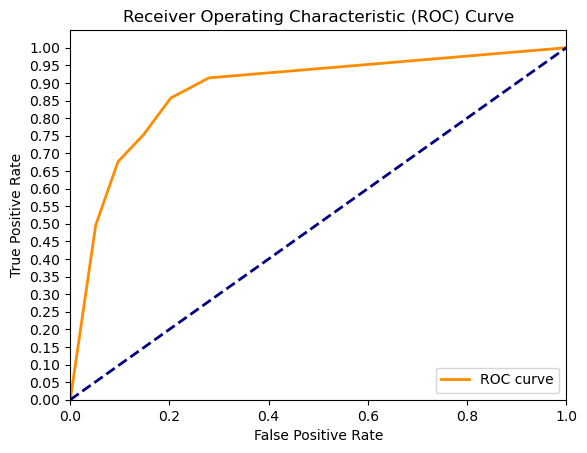

In [32]:
model_knn.plot_roc_curve(X_test_scaled, y_test)

## 3. `Decision Trees Model`

In [33]:
classifier = DecisionTreeClassifier()
model_tree = BinaryClassificationModel(classifier)

model_tree.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_tree.evaluate(y_test)

The model has an AUC score of 75.56%
-----------------------------------------------
The model's recall rate is 87.34%
-----------------------------------------------
The model's precision is 90.16%
-----------------------------------------------
The model's F1 score is 88.47%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       977
           1       0.40      0.61      0.48       105

    accuracy                           0.87      1082
   macro avg       0.68      0.76      0.71      1082
weighted avg       0.90      0.87      0.88      1082



In [34]:
model_tree.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 0.0
Test set F1 score: 0.48301886792452836


/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


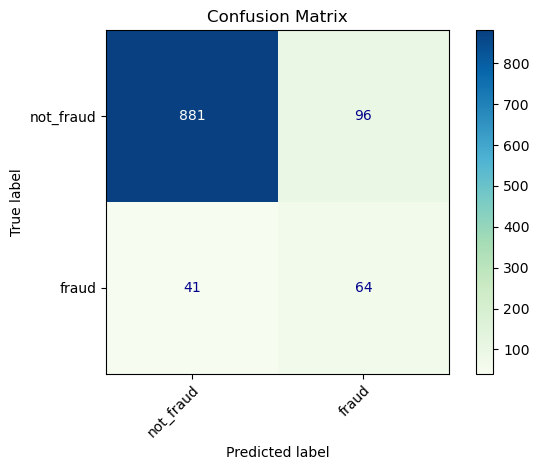

In [35]:
model_tree.plot_confusion_matrix(y_test)

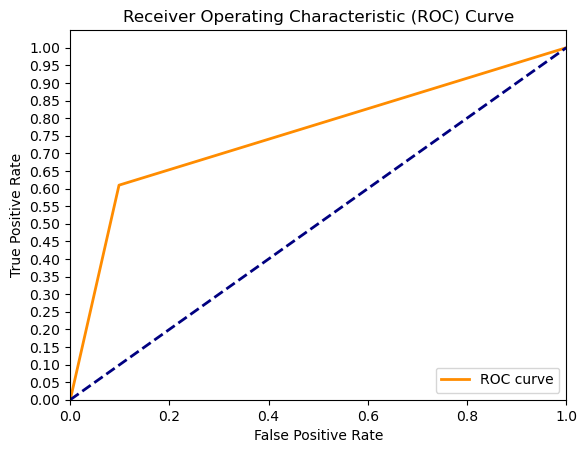

In [36]:
model_tree.plot_roc_curve(X_test_scaled, y_test)

## 4. `SVM`

In [37]:
classifier = SVC()
model_svm = BinaryClassificationModel(classifier)

model_svm.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_svm.evaluate(y_test)

The model has an AUC score of 84.39%
-----------------------------------------------
The model's recall rate is 87.15%
-----------------------------------------------
The model's precision is 92.28%
-----------------------------------------------
The model's F1 score is 88.87%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.42      0.81      0.55       105

    accuracy                           0.87      1082
   macro avg       0.70      0.84      0.74      1082
weighted avg       0.92      0.87      0.89      1082



In [38]:
model_svm.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Train set F1 score: 0.0
Test set F1 score: 0.5501618122977346


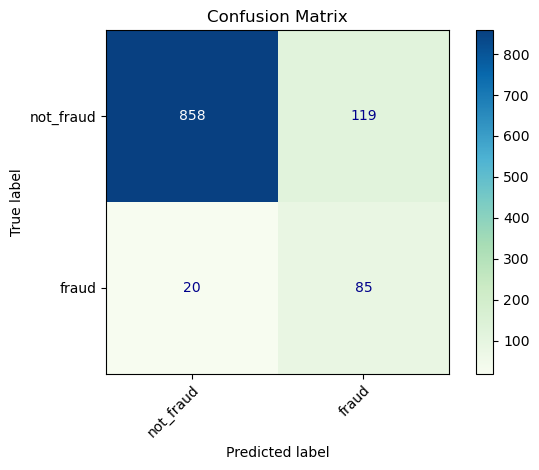

In [39]:
model_svm.plot_confusion_matrix(y_test)

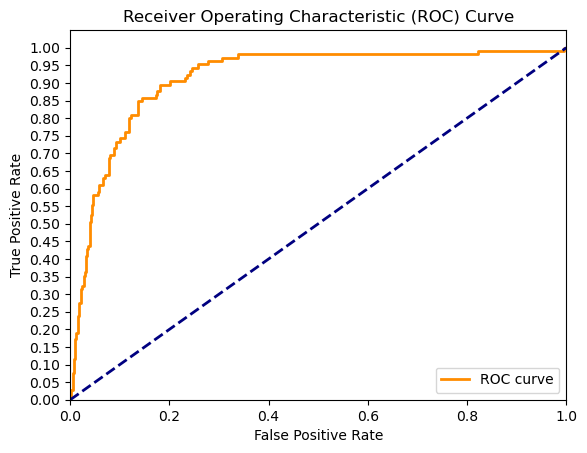

In [40]:
model_svm.plot_roc_curve(X_test_scaled, y_test)

## 5. `Gradientboost model`

In [41]:
classifier = GradientBoostingClassifier()
model_g = BinaryClassificationModel(classifier)

model_g.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_g.evaluate(y_test)

The model has an AUC score of 85.07%
-----------------------------------------------
The model's recall rate is 87.62%
-----------------------------------------------
The model's precision is 92.50%
-----------------------------------------------
The model's F1 score is 89.24%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.43      0.82      0.56       105

    accuracy                           0.88      1082
   macro avg       0.70      0.85      0.74      1082
weighted avg       0.93      0.88      0.89      1082



In [42]:
model_g.evaluate_overfitting(x_train_st, y_train_st, X_test, y_test)

Train set F1 score: 0.0
Test set F1 score: 0.5620915032679739


/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


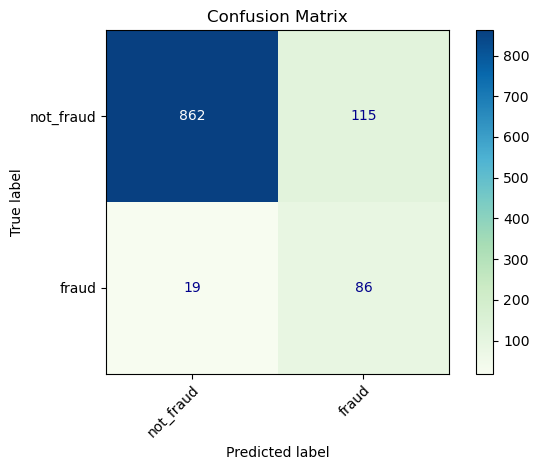

In [43]:
model_g.plot_confusion_matrix(y_test)

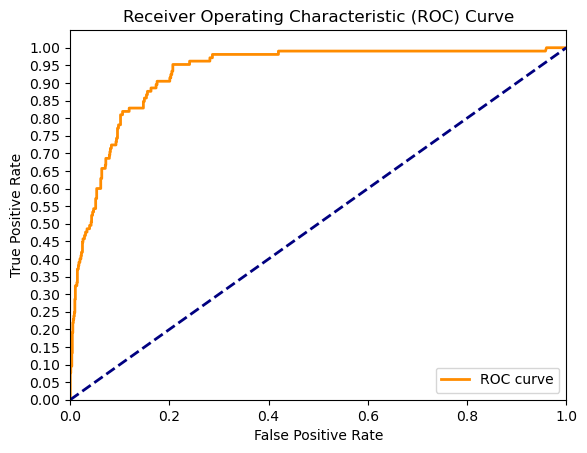

In [44]:
model_g.plot_roc_curve(X_test_scaled, y_test)

## 5. `Logistic regression Model`

In [45]:
classifier = LogisticRegression(random_state=42)
model_log = BinaryClassificationModel(classifier)

model_log.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_log.evaluate(y_test)

The model has an AUC score of 82.88%
-----------------------------------------------
The model's recall rate is 88.26%
-----------------------------------------------
The model's precision is 92.05%
-----------------------------------------------
The model's F1 score is 89.60%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       977
           1       0.44      0.76      0.56       105

    accuracy                           0.88      1082
   macro avg       0.71      0.83      0.74      1082
weighted avg       0.92      0.88      0.90      1082



/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
model_log.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 0.6668388429752066
Test set F1 score: 0.5574912891986062


/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


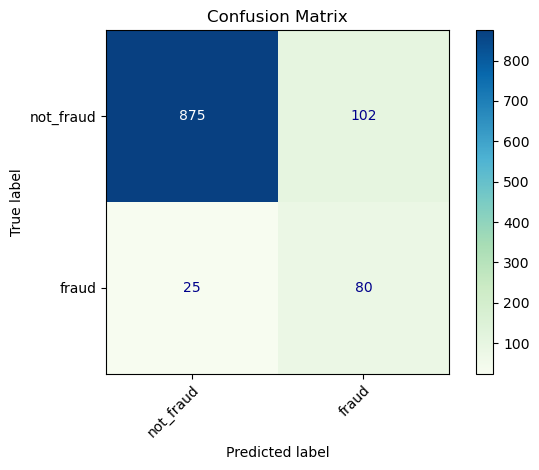

In [47]:
model_log.plot_confusion_matrix(y_test)

/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


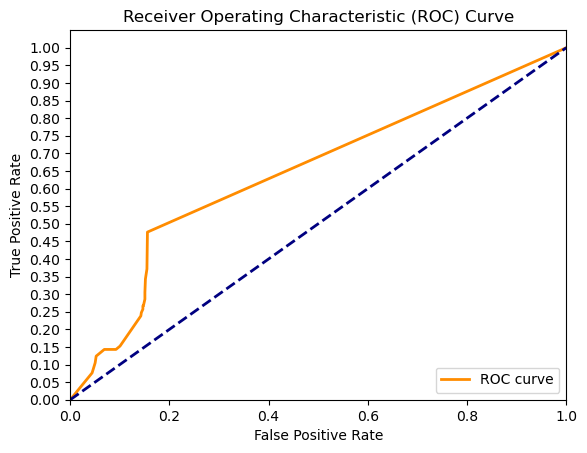

In [48]:
model.plot_roc_curve(X_test_scaled, y_test)

## 6. `XGBoost`

In [49]:
classifier = XGBClassifier()
model_xg = BinaryClassificationModel(classifier)

model_xg.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_xg.evaluate(y_test)

The model has an AUC score of 79.85%
-----------------------------------------------
The model's recall rate is 90.48%
-----------------------------------------------
The model's precision is 91.87%
-----------------------------------------------
The model's F1 score is 91.05%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       977
           1       0.51      0.67      0.58       105

    accuracy                           0.90      1082
   macro avg       0.74      0.80      0.76      1082
weighted avg       0.92      0.90      0.91      1082



In [50]:
model_xg.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5761316872427984


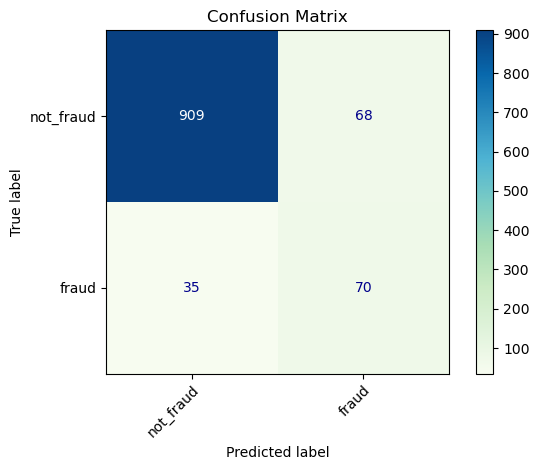

In [51]:
model_xg.plot_confusion_matrix(y_test)

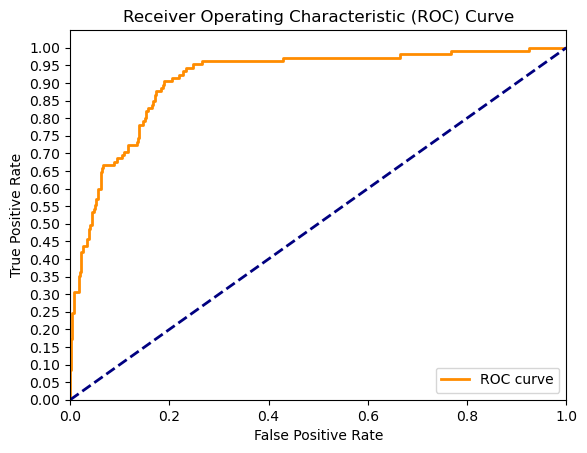

In [52]:
model_xg.plot_roc_curve(X_test_scaled, y_test)

hypertuning the XGboost

In [55]:
class XGBoostModel:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_estimator = None
    
    def train_best_estimator(self, X_train, y_train):
        self.best_estimator = XGBClassifier(subsample=1, n_estimators=100, max_depth=3, colsample_bytree=1, learning_rate=0.1, random_state=self.random_state)
        self.best_estimator.fit(X_train, y_train)
    
    def evaluate_best_estimator(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        train_y_pred_binary = (y_pred >= 0.5).astype(int)
    # Calculate evaluation metrics
        auc = roc_auc_score(y_test, train_y_pred_binary)
        recall = recall_score(y_test, train_y_pred_binary, average='weighted')
        precision = precision_score(y_test, train_y_pred_binary, average='weighted')
        f1 = f1_score(y_test, train_y_pred_binary, average='weighted')

    # Print evaluation metrics
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall:.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision:.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1:.2%}")
        print("-----------------------------------------------")

    # Print classification report
        print("Classification Report:")
        print(classification_report(y_test, train_y_pred_binary))
    
    def display_confusion_matrix(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.title('Confusion matrix')
        plt.show()

    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.best_estimator.predict(X_train)
        test_pred = self.best_estimator.predict(X_test)

        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)

In [56]:
# Instantiate the XGBoostModel class
modelxg = XGBoostModel(random_state=42)

# Train the model
modelxg.train_best_estimator(X_train_scaled, y_train_st)


In [57]:
# Evaluate the model
modelxg.evaluate_best_estimator(X_test_scaled, y_test)

The model has an AUC score of 83.50%
-----------------------------------------------
The model's recall rate is 86.32%
-----------------------------------------------
The model's precision is 91.98%
-----------------------------------------------
The model's F1 score is 88.22%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       977
           1       0.40      0.80      0.53       105

    accuracy                           0.86      1082
   macro avg       0.69      0.84      0.73      1082
weighted avg       0.92      0.86      0.88      1082



In [58]:
modelxg.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

Train set F1 score: 0.9282187618685911
Test set F1 score: 0.5316455696202532


In [59]:
# Instantiate the RandomForestClassifier model
class ModelEvaluationPlots:
    def __init__(self, model):
        self.model = model
    
    def plot_learning_curves(self, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5):
        train_sizes, train_scores, val_scores = learning_curve(self.model, X, y, cv=cv, train_sizes=train_sizes)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score', color='blue')
        plt.plot(train_sizes, val_mean, label='Validation score', color='red')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
        plt.xlabel('Training Set Size')
        plt.ylabel('Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    def plot_validation_curves(self, X, y, param_name, param_range, cv=5):
        train_scores, val_scores = validation_curve(self.model, X, y, param_name=param_name, param_range=param_range, cv=cv)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(param_range, train_mean, label='Training score', color='blue')
        plt.plot(param_range, val_mean, label='Validation score', color='red')
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
        plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.title('Validation Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()


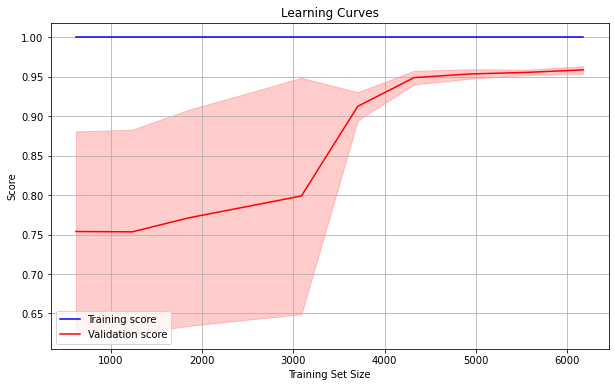

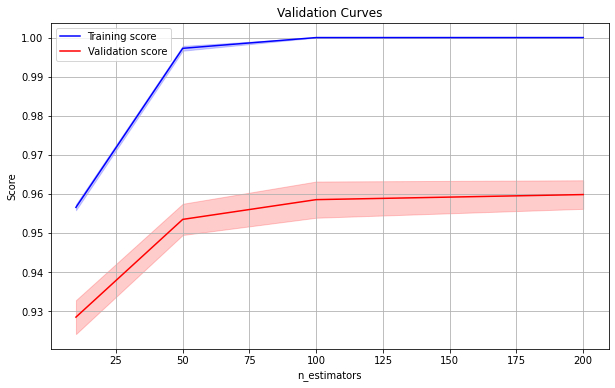

In [60]:
model_xgo = XGBClassifier()  # Instantiate your model
eval_plots = ModelEvaluationPlots(model_xgo)  # Create an instance of the ModelEvaluationPlots class

# Generate and plot learning curves
eval_plots.plot_learning_curves(X_train_scaled, y_train_st)

# Generate and plot validation curves
param_range = [10, 50, 100, 200]  # Example hyperparameter values to vary
eval_plots.plot_validation_curves(X_train_scaled, y_train_st, param_name='n_estimators', param_range=param_range)


### `Regularization to reduce overfitting`

In [61]:
# Create an instance of XGBClassifier with increased regularization, reduced complexity, and increased learning rate
xgb_model = XGBClassifier(subsample=1, n_estimators=100, max_depth=2, colsample_bytree=0.8,
                          learning_rate=0.3, reg_alpha=1, reg_lambda=1, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train_st)

# Evaluate the model
train_pred = xgb_model.predict(X_train_scaled)
test_pred = xgb_model.predict(X_test_scaled)

train_f1 = f1_score(y_train_st, train_pred)
test_f1 = f1_score(y_test, test_pred)

print("Train set F1 score:", train_f1)
print("Test set F1 score:", test_f1)



Train set F1 score: 0.9418619379354021
Test set F1 score: 0.5551839464882943


In [62]:
model.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5666666666666667


c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


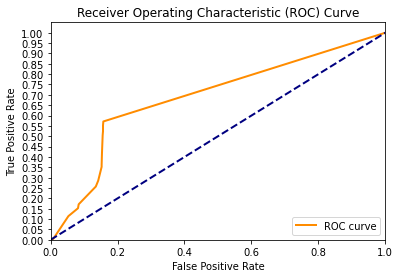

In [63]:
model.plot_roc_curve(X_test_scaled, y_test)

### "Ensemble Model Evaluation with Voting Classifier".

In [64]:
# Define the individual models
model_1 = XGBClassifier(subsample=1, n_estimators=100, max_depth=3, colsample_bytree=1, learning_rate=0.1,
                        reg_alpha=0.1, reg_lambda=0.1, random_state=42)
model_2 = XGBClassifier(subsample=1, n_estimators=200, max_depth=5, colsample_bytree=0.8, learning_rate=0.2,
                        reg_alpha=0.5, reg_lambda=0.5, random_state=42)

# Create the voting ensemble
voting_model = VotingClassifier(estimators=[('xgb_model_1', model_1), ('xgb_model_2', model_2)], voting='soft')

# Train the voting model
voting_model.fit(X_train_scaled, y_train_st)

# Evaluate the voting model
train_pred = voting_model.predict(X_train_scaled)
test_pred = voting_model.predict(X_test_scaled)

train_f1 = f1_score(y_train_st, train_pred)
test_f1 = f1_score(y_test, test_pred)

print("Train set F1 score:", train_f1)
print("Test set F1 score:", test_f1)

Train set F1 score: 0.9897198663582626
Test set F1 score: 0.5606060606060607


In [65]:
model.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5666666666666667


c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


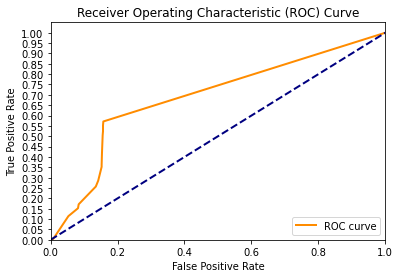

In [66]:
model.plot_roc_curve(X_test_scaled, y_test)

## 7. `Random Forest Model`

In [53]:
classifier = RandomForestClassifier()
model_ran = BinaryClassificationModel(classifier)

model_ran.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_ran.evaluate(y_test)

The model has an AUC score of 80.64%
-----------------------------------------------
The model's recall rate is 91.13%
-----------------------------------------------
The model's precision is 92.24%
-----------------------------------------------
The model's F1 score is 91.58%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       977
           1       0.53      0.68      0.60       105

    accuracy                           0.91      1082
   macro avg       0.75      0.81      0.77      1082
weighted avg       0.92      0.91      0.92      1082



In [54]:
model_ran.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 0.6843407564510428
Test set F1 score: 0.596638655462185


/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


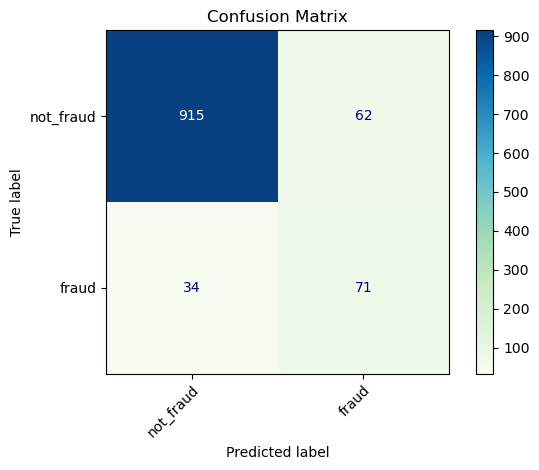

In [55]:
model_ran.plot_confusion_matrix(y_test)

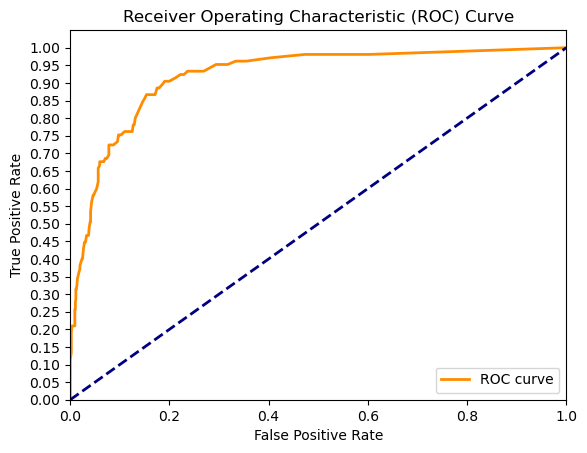

In [56]:
model_ran.plot_roc_curve(X_test_scaled, y_test)

`Hyper tuning the Random Forest model`

In [62]:
class RandomForestEnsemble:
    def __init__(self, n_estimators_list, max_depth_list):
        self.n_estimators_list = n_estimators_list
        self.max_depth_list = max_depth_list
        self.models = []

    def fit(self, X_train, y_train):
        for n_estimators, max_depth in zip(self.n_estimators_list, self.max_depth_list):
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            model.fit(X_train, y_train)
            self.models.append(model)

    def predict(self, X_test):
        predictions = []
        for model in self.models:
            pred = model.predict(X_test)
            predictions.append(pred)
        ensemble_pred = sum(predictions) / len(predictions)  # Soft voting
        ensemble_pred_binary = (ensemble_pred >= 0.5).astype(int)  # Convert to binary
        return ensemble_pred_binary

In [63]:
ensemble = RandomForestEnsemble(n_estimators_list=[100, 500, 200], max_depth_list=[10, 5, 8])
ensemble.fit(X_train_scaled, y_train_st)

In [59]:
model.evaluate_overfitting(x_train_st, y_train_st, X_test_scaled, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5641025641025641


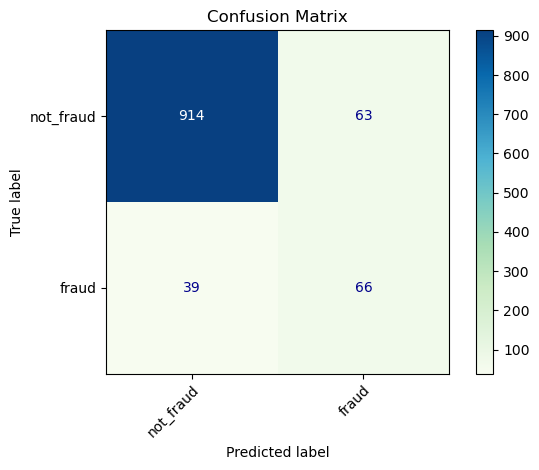

In [60]:
model.plot_confusion_matrix(y_test)

/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


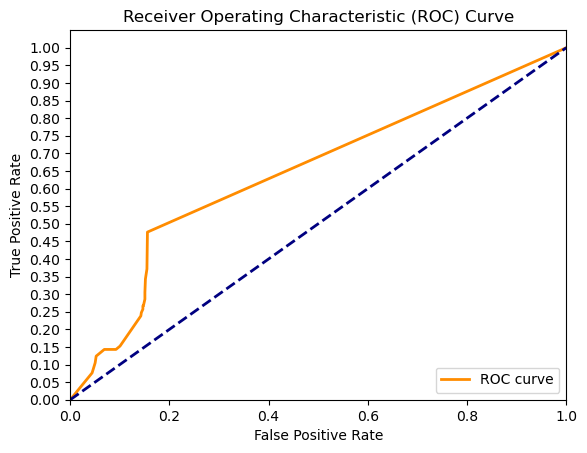

In [61]:
model.plot_roc_curve(X_test_scaled, y_test)

`Grid search for random forest`

In [66]:
# create a grid of parameters to test
param_grid = [{
        'criterion': ['entropy'], 
        'max_depth': [13], 
        'max_features': ['log2'], 
        'max_leaf_nodes': [50], 
        'min_samples_leaf': [2], 
        'min_samples_split': [10], 
        'n_estimators': [1000]
}]
# create grid with estimators
gridsearch_forest = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                            param_grid=param_grid,
                            scoring="accuracy",
                            cv=5,
                            n_jobs=1)
# fit the grid with the data
gridsearch_forest.fit(x_train_os, y_train_os)
# Get the best parameters
print("Best Parameters:", gridsearch_forest.best_params_)
# Make predictions on the test data using the trained pipeline
y_pred_gridsearch = gridsearch_forest.predict(X_test_scaled)
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearch))

Best Parameters: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       977
           1       0.00      0.00      0.00       105

    accuracy                           0.90      1082
   macro avg       0.45      0.50      0.47      1082
weighted avg       0.82      0.90      0.86      1082



/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kinoti/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined 

In [70]:
# Initial evaluation to check for performance
classifier = RandomForestClassifier(random_state=42)
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_os, y_train_os, X_test)
model.evaluate(y_test)

The model has an AUC score of 72.55%
-----------------------------------------------
The model's recall rate is 91.87%
-----------------------------------------------
The model's precision is 91.23%
-----------------------------------------------
The model's F1 score is 91.48%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       977
           1       0.60      0.49      0.54       105

    accuracy                           0.92      1082
   macro avg       0.77      0.73      0.75      1082
weighted avg       0.91      0.92      0.91      1082



In [71]:
# Instantiate the classifier with the obtained best_params
classifier = RandomForestClassifier(criterion='entropy', 
                                    max_depth=13, 
                                    max_features='log2', 
                                    max_leaf_nodes=50, 
                                    min_samples_leaf=2, 
                                    min_samples_split=10, 
                                    n_estimators=1000,
                                    random_state=42)
model = BinaryClassificationModel(classifier)

model.train_and_predict(x_train_os, y_train_os, X_test)
model.evaluate(y_test)

The model has an AUC score of 83.28%
-----------------------------------------------
The model's recall rate is 89.00%
-----------------------------------------------
The model's precision is 92.27%
-----------------------------------------------
The model's F1 score is 90.16%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       977
           1       0.46      0.76      0.57       105

    accuracy                           0.89      1082
   macro avg       0.72      0.83      0.76      1082
weighted avg       0.92      0.89      0.90      1082



# `Conclusions and Recommendation`